In [1]:
import os
from pathlib import Path


def add_to_gitignore(filename):
    
    if not os.path.exists(".gitignore"):
        Path('.gitignore').touch()
    
    with open(".gitignore", "r") as gitignore:
        lines = gitignore.readlines()
        is_ignored=False
        for line in lines:
            if filename in line:
                is_ignored = True

    if not is_ignored:
        with open(".gitignore", "a") as gitignore:
            gitignore.write(f"\n{filename}")

In [14]:
import shutil
import rarfile
import getpass
import requests
import webbrowser
import matplotlib
import pandas
from termcolor import colored
from matplotlib import pyplot
import matplotlib.patches as mpatches

from matplotlib.ticker import FuncFormatter


add_to_gitignore("__pycache__")
add_to_gitignore(".ipynb_checkpoints")

directory = os.path.join("data", "2018")

if os.path.exists(directory):
    shutil.rmtree("data")
os.makedirs(directory)

add_to_gitignore("data")

url = "https://www.policie.cz/soubor/datagis-rok-2018-rar.aspx"
r = requests.get(url, allow_redirects=True)
if r.status_code != 200:
    print("Failed to retrieve data, please get them manually from: \nhttps://www.policie.cz/clanek/statistika-nehodovosti-900835.aspx?q=Y2hudW09Mg%3d%3d")
    webbrowser.open('https://www.policie.cz/clanek/statistika-nehodovosti-900835.aspx?q=Y2hudW09Mg%3d%3d')
    raise SystemExit("Failed to retrieve data from PČR, waiting for user to get them manually")
    
    
filename = "policedata.rar"
with open(filename, "wb") as file:
    file.write(r.content)

add_to_gitignore("policedata.rar")

rar_file = rarfile.RarFile(filename)
rar_file.extractall(directory)

explanations_file_path = "explanations.py"
if not os.path.exists(explanations_file_path):
    session = requests.Session()
    url = "https://courses.fit.cvut.cz/MI-PYT/_tasks/pandas/explanations.py"
    r = session.get(url, allow_redirects=True)
    if "text/html" in r.headers["Content-Type"]:
        success = False
        while not success:
            username = input("CTU Username: ")
            print("CTU password: ", end="")
            password = getpass.getpass()

            login_details = {"j_username": username, "j_password": password}
            r = session.post("https://auth.fit.cvut.cz/login.do", data=login_details, allow_redirects=True)
            if "Username or password is invalid." not in r.text:
                success = True
            else:
                print(colored("Something went wrong, maybe bad username or password? IDK", "red"))

        if "application/octet-stream" in r.headers["Content-Type"]:
            with open(explanations_file_path, "wb") as file:
                file.write(r.content)
        else:
            print(colored("After a successfull login, still no file. Weird", "red"))
            print("Download the file manually from: \nhttps://courses.fit.cvut.cz/MI-PYT/_tasks/pandas/explanations.py")

            webbrowser.open('https://courses.fit.cvut.cz/MI-PYT/_tasks/pandas/explanations.py')
            raise SystemExit("A file has not been downloaded, so lets wait for the user to do it manually")

In [3]:
import explanations

add_to_gitignore("explanations.py")

all_region_list = []
for filename, title in explanations.file_names.items():
    one_region = pandas.read_csv(os.path.join(directory, filename), sep=";", decimal=",", dtype={56: "str"}, encoding='iso-8859-2')
    one_region.columns = explanations.main_columns
    one_region["kraj"] = title
    all_region_list.append(one_region)
    
all_regions = pandas.concat(all_region_list)

In [4]:
pedestrians = pandas.read_csv(os.path.join(directory, "CHODCI.csv"), sep=";", decimal=",", encoding='iso-8859-2')
pedestrians.columns = explanations.ped_columns

print(f"Počet unikátních identifikačních čísel v souboru chodci: {len(pandas.unique(pedestrians['identifikacni_cislo']))}")
print(f"Celkový počet řádků: {len(pedestrians['identifikacni_cislo'])}")
      
unique_pedestrians = pedestrians.drop_duplicates(['identifikacni_cislo'])

Počet unikátních identifikačních čísel v souboru chodci: 3730
Celkový počet řádků: 3731


In [5]:
full_table = all_regions.merge(unique_pedestrians, how="outer")
full_table = full_table.replace(explanations.decode_key)
full_table = full_table.set_index("identifikacni_cislo")
full_table = full_table.dropna(axis=1, how="all")

In [6]:
full_table.to_csv("clean-2018.csv")
add_to_gitignore("clean-2018.csv")

In [7]:
rowcount = len(full_table.index)
print(f"V roce 2018 bylo PČR zaznamenáno {rowcount} nehod.")

V roce 2018 bylo PČR zaznamenáno 104750 nehod.


In [8]:
deadly_accidents = full_table[full_table["usmrceno_osob"] > 0]
deadly_accident_count = deadly_accidents["usmrceno_osob"].count()
percentage = 100 * (deadly_accident_count / rowcount)
print(f"Z toho bylo {round(percentage, 2)}% smrtelných.")

Z toho bylo 0.49% smrtelných.


In [9]:
reflective_accidents = deadly_accidents[deadly_accidents["druh_pevne_prekazky"].str.contains("odrazník")]
reflective_deaths = reflective_accidents["usmrceno_osob"].sum()
print(f"Srážkou se značkou/odrazníkem zemřeli {reflective_deaths} lidé.")

Srážkou se značkou/odrazníkem zemřeli 4 lidé.


In [10]:
tram_accidents = full_table[full_table["situovani_nehody_na_komunikaci"] == "na kolejích tramvaje"]
tram_accident_count = len(tram_accidents.index)
deadly_tram_accident_count = len(tram_accidents[tram_accidents["usmrceno_osob"] > 0].index)
tram_percentage = deadly_tram_accident_count / tram_accident_count * 100
print(f"Na kolejích tramvaje bylo z {tram_accident_count}ti nehod {round(tram_percentage, 2)}% smrtelných")

Na kolejích tramvaje bylo z 912ti nehod 0.88% smrtelných


In [11]:
copy_full_table = full_table.copy()
copy_full_table["Počet nehod"]=1

curved_table = full_table[full_table["smerove_pomery"] == "zatáčka"].copy()
curved_table["Z toho v zatáčce"]=1

all_by_brand_crowded = copy_full_table.groupby('vyrobni_znacka_motoroveho_vozidla').count()
curved_by_brand_crowded = curved_table.groupby('vyrobni_znacka_motoroveho_vozidla').count()

all_by_brand = all_by_brand_crowded.reindex(axis="columns", labels=["Počet nehod"], )
curved_by_brand = curved_by_brand_crowded.reindex(axis="columns", labels=["Z toho v zatáčce"])
brands_compared = all_by_brand.join(curved_by_brand).fillna(0).astype(dtype={"Z toho v zatáčce": int})

prominent_brands_compared = brands_compared[brands_compared["Počet nehod"] >= 50].copy()

prominent_brands_compared["Procento nehod v zatáčce"] = round(prominent_brands_compared["Z toho v zatáčce"] / prominent_brands_compared["Počet nehod"] * 100, 2)

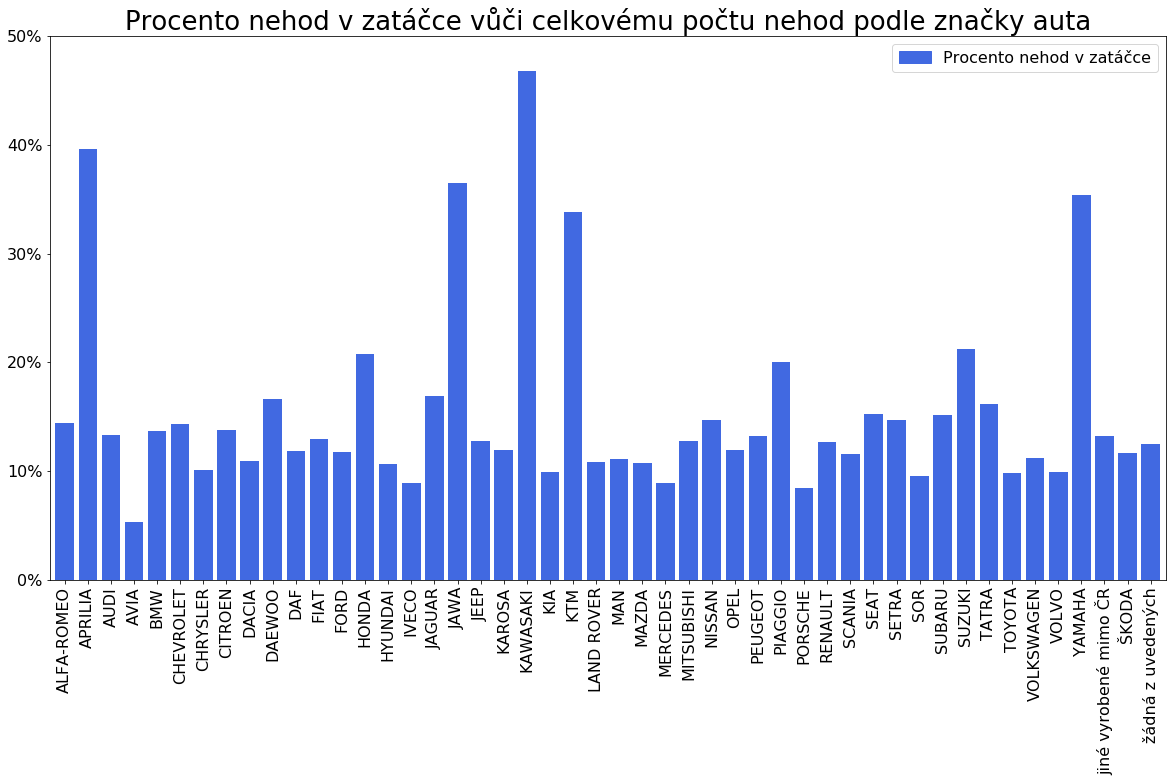

In [12]:
fontsize = 16

axes = pyplot.gca()

prominent_brands_compared["Procento nehod v zatáčce"].plot.bar(figsize=(20,10), width=0.8, fontsize=fontsize, ax=axes, color="royalblue")

axes.set_xlabel("")

axes.set_ylim(0, 50)
axes.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%')) #show percentage sign

blue_patch = mpatches.Patch(color='royalblue', label='Procento nehod v zatáčce')

pyplot.legend(handles=[blue_patch], fontsize=fontsize)

pyplot.title("Procento nehod v zatáčce vůči celkovému počtu nehod podle značky auta", fontsize=26)

pyplot.show()